# 🔌 Prédiction du prix de l'électricité sur le marché indien 🇮🇳

### 🧠 Contexte du projet

Dans le cadre d’une opportunité avec **ENGIE** pour une mission en Inde, il m’a été proposé, à l’issue du deuxième entretien, de partager des projets personnels supplémentaires. J’ai décidé de relever ce défi en construisant un modèle de **prédiction du prix de l’électricité (MCP - Market Clearing Price)** sur le marché indien, en seulement quelques jours.

L’objectif est double :

* **Démontrer mes compétences techniques** (collecte et traitement de données, machine learning, visualisation, analyse),
* **Explorer une problématique concrète** au croisement de la data science et des enjeux énergétiques.

### 📦 Jeux de données utilisés

Les données proviennent de deux sources publiques sur Kaggle :

* 📈 **Prix de l’électricité (2019–2024)**
  *Indian Energy Exchange - Time Series Forecasting*
  [Lien Kaggle](https://www.kaggle.com/datasets/mukund604/indian-energy-exchange-time-series-forecasting)

* ⚡ **Production d’électricité par source (2013–2023)**
  *Daily Power Generation in India \[2013–2023]*
  [Lien Kaggle](https://www.kaggle.com/datasets/krishnadaskv/daily-power-generation-in-india-2013-2023)

Ces données ont été croisées avec des **données météorologiques** externes (via API) afin de mieux modéliser les dynamiques de prix.

### ⚙️ Objectif

L'objectif est de **prédire le MCP** à l’aide d’un modèle de machine learning, en s’appuyant sur :

* La production d’électricité (par source : nucléaire, solaire, charbon, etc.),
* Les conditions météorologiques (températures, radiation, etc.),
* Et d’autres indicateurs agrégés comme la production totale.

---

### 📚 Installation et Importation

In [268]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost requests


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [223]:
# 🔧 Manipulation des données
import pandas as pd
import numpy as np

# 📊 Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# 🤖 Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 🌲 XGBoost
from xgboost import XGBRegressor

# 🌐 API météo (optionnel)
import requests

# 📚 Importation de la data

In [224]:
# Afficher toutes les colonnes de pandas
pd.set_option('display.max_columns', None)

# Chargement des données de production d’électricité en Inde
df_production = pd.read_csv("Daily_Power_Gen_Source_march_23.csv", parse_dates=["date"])

# Chargement des prix spot de l’électricité (DAM)
df_price = pd.read_excel("DAM.xlsx", parse_dates=["TimeStamp"])

# Aperçu rapide
display(df_production.head())
display(df_price.head())

,source,NR,WR,SR,ER,NER,All India,date
0,Hydro,139.0,43.0,72.0,30.0,7.0,292,2013-03-31
1,Total,675.0,820.0,697.0,306.0,28.0,2526,2013-03-31
2,Wind Gen(MU),2.0,19.0,13.0,0.0,0.0,34,2013-03-31
3,Hydro,137.0,43.0,83.0,32.0,5.0,300,2013-04-01
4,Total,683.0,841.0,706.0,316.0,29.0,2575,2013-04-01


,TimeStamp,Purchase Bid (MW),Sell Bid (MW),MCV (MW),Final Scheduled Volume (MW),MCP (Rs/MWh) *,Weighted MCP (Rs/MWh)
0,2018-01-01 00:00:00,3269.1,12568.1,2792.6,2792.6,1999.21,1999.21
1,2018-01-01 00:15:00,3252.4,12876.3,2792.3,2792.3,1899.96,1899.96
2,2018-01-01 00:30:00,3234.3,13028.8,2774.2,2774.2,1899.51,1899.51
3,2018-01-01 00:45:00,3217.7,13222.7,2757.6,2757.6,1899.13,1899.13
4,2018-01-01 01:00:00,2981.0,13906.1,2533.9,2533.9,1819.77,1819.77


> 🎯 **Objectif** : Pour chaque jour, avoir **une seule ligne**, avec une colonne par `source` (ex: `Coal`, `Hydro`, etc.) contenant la **production "All India"**.

---

### ✅ Résultat final attendu (exemple)

| date       | Coal | Hydro | Solar | Gas | ... |
| ---------- | ---- | ----- | ----- | --- | --- |
| 2019-01-01 | 2646 | 242   | 94    | 122 | ... |
| 2019-01-02 | ...  | ...   | ...   | ... | ... |

---

### 🔧 Étapes du traitement

1. Charger le fichier
2. Filtrer uniquement les lignes `All India`
3. Garder les colonnes `date`, `source`, `All India`
4. **Pivoter** pour transformer les `sources` en **colonnes**
5. Obtenir un **DataFrame propre et agrégé par jour**

---


In [225]:
# Filtrer les lignes "All India"
df_filtered = df_prod[['date', 'source', 'All India']].copy()

# Supprimer les lignes sans valeur "All India"
df_filtered = df_filtered.dropna(subset=['All India'])

# Pivot : sources deviennent des colonnes
df_pivot = df_filtered.pivot_table(
    index='date',
    columns='source',
    values='All India',
    aggfunc='sum'  # en cas de doublons
)

# Réinitialiser l’index
df_pivot = df_pivot.reset_index()

# Affichage
print("✅ DataFrame final : une ligne par jour, une colonne par source d'énergie")
df_pivot.head()


✅ DataFrame final : une ligne par jour, une colonne par source d'énergie


source,date,Coal,"Gas, Naptha & Diesel",Hydro,Lignite,Nuclear,"RES (Wind, Solar, Biomass & Others)",Solar Gen (MU),Thermal (Coal & Lignite),Total,Wind Gen(MU)
0,2013-03-31,NaN,NaN,292.0,NaN,NaN,NaN,NaN,NaN,2526.0,34.0
1,2013-04-01,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,2575.0,48.0
2,2013-04-02,NaN,NaN,290.0,NaN,NaN,NaN,NaN,NaN,2558.0,48.0
3,2013-04-03,NaN,NaN,299.0,NaN,NaN,NaN,NaN,NaN,2551.0,31.0
4,2013-04-04,NaN,NaN,297.0,NaN,NaN,NaN,NaN,NaN,2586.0,42.0


---

## 📌 Observation

On remarque qu’il y a **beaucoup de `NaN` au début**. C’est tout à fait normal :

* Certaines sources comme `Coal`, `Lignite`, etc., apparaissent **progressivement** dans le dataset.
* D'autres comme `Solar Gen (MU)` ou `Wind Gen (MU)` sont peut-être **documentées plus tard ou partiellement**.


In [226]:
# Nettoyage : remplacer NaN par 0, uniformiser les noms
df_pivot_cleaned = df_pivot.fillna(0)

df_pivot_cleaned.columns = (
    df_pivot_cleaned.columns
    .str.replace(r"\(.*?\)", "", regex=True)
    .str.replace("Gen", "", regex=False)
    .str.replace("MU", "", regex=False)
    .str.replace("&", "and", regex=False)
    .str.replace(",", "", regex=False)
    .str.replace("  ", " ", regex=False)
    .str.replace(" ", "_", regex=False)
    .str.strip()
)

# Affichage final
df_pivot_cleaned.head()

source,date,Coal,Gas_Naptha_and_Diesel,Hydro,Lignite,Nuclear,RES_,Solar_,Thermal_,Total,Wind_
0,2013-03-31,0.0,0.0,292.0,0.0,0.0,0.0,0.0,0.0,2526.0,34.0
1,2013-04-01,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,2575.0,48.0
2,2013-04-02,0.0,0.0,290.0,0.0,0.0,0.0,0.0,0.0,2558.0,48.0
3,2013-04-03,0.0,0.0,299.0,0.0,0.0,0.0,0.0,0.0,2551.0,31.0
4,2013-04-04,0.0,0.0,297.0,0.0,0.0,0.0,0.0,0.0,2586.0,42.0


## 👀 Hypothèses possibles : 

On a mis le doigt sur quelque chose d’important :
la colonne `Total` ne correspond **pas à la somme des colonnes `Coal`, `Hydro`, etc.\`**
👉 ce qui peut indiquer que :

---

### 🧠 Hypothèses possibles :

### 🔍  **`Total` vient d'une ligne différente**

Il est probable que dans le fichier d’origine, la **ligne "Total" est une ligne distincte**, comme `source == "Total"`, et non la somme des autres sources dans la table pivot.

➡️ En d'autres termes, **on a une ligne "Total" par jour dans les données brutes**, et on l'a pivotée comme les autres.


---

## 🎯 Objectif df_price :

À partir du fichier brut contenant des données toutes les 15 minutes :

| TimeStamp           | Purchase Bid | Sell Bid | MCP | ... |
| ------------------- | ------------ | -------- | --- | --- |
| 2018-01-01 00:00:00 | ...          | ...      | ... |     |
| 2018-01-01 00:15:00 | ...          | ...      | ... |     |

On veut obtenir :

| date       | Purchase Bid (sum) | MCP (mean) | ... |
| ---------- | ------------------ | ---------- | --- |
| 2018-01-01 | 58 000             | 1955.36    |     |

---

## ✅ Étapes à suivre

### 1. Charger le fichier

### 2. Extraire la date

### 3. Agréger par jour

* Somme pour : `Purchase Bid`, `Sell Bid`, `MCV`, `Final Scheduled Volume`
* Moyenne pour : `MCP`, `Weighted MCP`

### 4. Nettoyer les noms de colonnes

---



In [227]:
#  Nettoyage initial des noms de colonnes
df_price.columns = (
    df_price.columns
    .str.replace(" ", "_")
    .str.replace(r"\(.*?\)", "", regex=True)
    .str.replace("*", "", regex=False)
    .str.strip()
)

# Extraction de la date
df_price["date"] = pd.to_datetime(df_price["TimeStamp"]).dt.date

# Agrégation quotidienne
df.rename(columns={
    'Purchase_Bid_': 'Purchase_Bid',
    'Sell_Bid_': 'Sell_Bid',
    'MCV_': 'MCV',
    'Final_Scheduled_Volume_': 'Final_Scheduled_Volume',
    'MCP__': 'MCP',
    'Weighted_MCP_': 'Weighted_MCP'
}, inplace=True)


# Résultat
df_price_daily.head()

,date,Purchase_Bid,Sell_Bid,MCV,Final_Scheduled_Volume,MCP,Weighted_MCP
0,2018-01-01,517573.3,878143.4,426314.76,425750.39,3149.720000,3149.720000
1,2018-01-02,471179.9,933524.3,405509.41,403052.31,2913.002500,2913.002500
2,2018-01-03,516813.0,844412.7,404354.16,400870.36,3171.739271,3171.739271
3,2018-01-04,505985.4,839719.3,393399.89,392022.68,3160.423750,3160.423750
4,2018-01-05,545624.8,910620.8,437868.70,436183.10,3133.624167,3133.624167


## 🧠 🔎 Analyse rapide du résultat

### ✅ Ce que l’on peut dire :

* **MCP (Market Clearing Price)** fluctue logiquement avec la **demande (Purchase Bid)**.
* Le marché semble assez **sensible aux variations de volume**, mais reste **globalement stable** sur cette période (\~3100 ₹/MWh).
* La **valeur moyenne pondérée** du MCP est égale ici car probablement peu de variation intra-journalière à ce stade.

---

In [228]:
import requests

def fetch_weather_data(start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 22.0,           # Centre géographique de l'Inde
        "longitude": 78.0,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,shortwave_radiation_sum,windspeed_10m_max",
        "timezone": "Asia/Kolkata"
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        df_weather = pd.DataFrame(response.json()["daily"])
        df_weather["time"] = pd.to_datetime(df_weather["time"])
        return df_weather
    else:
        print("Erreur de récupération météo:", response.status_code)
        return pd.DataFrame()

# météo quotidienne pour 2019 à 2023
df_weather = fetch_weather_data("2019-01-01", "2023-12-31")

df_weather.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,shortwave_radiation_sum,windspeed_10m_max
0,2019-01-01,26.7,10.8,0.0,15.95,10.8
1,2019-01-02,27.2,11.9,0.0,16.48,11.6
2,2019-01-03,26.7,12.2,0.0,16.54,12.3
3,2019-01-04,27.1,12.8,0.0,16.63,12.0
4,2019-01-05,27.2,15.8,0.0,15.98,20.1


On a maintenant les **données météo journalières en Inde de 2019 à 2023**.

## ✅ Étape suivante : Nettoyage et préparation de `df_weather`

Voici les étapes pour le nettoyage :

1. Renommer les colonnes pour les harmoniser
2. Convertir `time` en `date` au bon format
3. Vérifier les doublons (au cas où)
4. Être prêt pour la **fusion finale** avec les datasets "production" et "prix"

---


In [229]:
# 1. Nettoyage des noms de colonnes
df_weather.columns = (
    df_weather.columns
    .str.replace("temperature_2m_", "temp_", regex=False)
    .str.replace("shortwave_radiation_sum", "radiation", regex=False)
    .str.replace("windspeed_10m_max", "wind", regex=False)
    .str.replace("precipitation_sum", "precip", regex=False)
)

# 2. Conversion datetime correcte
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather["date"] = df_weather["time"].dt.date
df_weather.drop(columns="time", inplace=True)

# 3. Suppression des doublons
df_weather = df_weather.drop_duplicates(subset="date")

# 4. Affichage
df_weather.head()


,temp_max,temp_min,precip,radiation,wind,date
0,26.7,10.8,0.0,15.95,10.8,2019-01-01
1,27.2,11.9,0.0,16.48,11.6,2019-01-02
2,26.7,12.2,0.0,16.54,12.3,2019-01-03
3,27.1,12.8,0.0,16.63,12.0,2019-01-04
4,27.2,15.8,0.0,15.98,20.1,2019-01-05


Parfait, maintenant nous pouvons essayer de fusionner nos datasets en un seul.
---

### 🔁 Les 3 datasets :

1. `df_pivot_cleaned` → 🏭 Production énergétique (`All India`, 1 ligne par jour)
2. `df_price_daily` → 💰 Prix et volumes du marché (agrégés par jour)
3. `df_weather` → 🌦️ Météo quotidienne centrale (Inde)

---

In [230]:
#  S’assurer que chaque DataFrame a bien une colonne 'date' au bon format
df_pivot_cleaned["date"] = pd.to_datetime(df_pivot_cleaned["date"])
df_price_daily["date"] = pd.to_datetime(df_price_daily["date"])
df_weather["date"] = pd.to_datetime(df_weather["date"])

#  Fusion : production + prix
df_merge_1 = pd.merge(df_pivot_cleaned, df_price_daily, on="date", how="inner")

# Ajout météo
df_final = pd.merge(df_merge_1, df_weather, on="date", how="inner")

# Résultat final
print("✅ Dataset final fusionné :")
print(f"Nombre de jours : {df_final.shape[0]}")
print(f"Nombre de colonnes : {df_final.shape[1]}")
df_final.head()

✅ Dataset final fusionné :
Nombre de jours : 1482
Nombre de colonnes : 22


,date,Coal,Gas_Naptha_and_Diesel,Hydro,Lignite,Nuclear,RES_,Solar_,Thermal_,Total,Wind_,Purchase_Bid,Sell_Bid,MCV,Final_Scheduled_Volume,MCP,Weighted_MCP,temp_max,temp_min,precip,radiation,wind
0,2019-01-01,2581.0,122.0,241.0,90.0,75.0,266.0,0.0,0.0,3376.0,0.0,593326.8,943843.0,394048.54,394214.98,3201.515833,3201.515833,26.7,10.8,0.0,15.95,10.8
1,2019-01-02,2611.0,124.0,247.0,94.0,76.0,261.0,0.0,0.0,3413.0,0.0,675841.0,894924.0,416838.24,415128.43,3531.382812,3531.382812,27.2,11.9,0.0,16.48,11.6
2,2019-01-03,2642.0,116.0,261.0,99.0,85.0,258.0,0.0,0.0,3461.0,0.0,573853.8,920352.5,372414.36,372196.10,3252.659271,3252.659271,26.7,12.2,0.0,16.54,12.3
3,2019-01-04,2663.0,130.0,242.0,96.0,87.0,267.0,0.0,0.0,3484.0,0.0,744967.6,846687.4,435651.84,435651.83,3758.001771,3758.001771,27.1,12.8,0.0,16.63,12.0
4,2019-01-05,2646.0,123.0,238.0,97.0,87.0,262.0,0.0,0.0,3454.0,0.0,658851.6,843551.1,414795.32,414795.32,3667.538646,3667.538646,27.2,15.8,0.0,15.98,20.1


Avant de se lancer dans un modèle, on va **visualiser les données** cela va nous permettre de :

* 🔍 Comprendre la structure, les corrélations, les éventuelles anomalies
* 📈 Identifier les relations non linéaires (par exemple entre production et MCP)
* 🧠 Adapter le choix du modèle

---

## 🎯 Objectifs de visualisation

Onva essayer d'**explorer intelligemment le dataset** :

---

### 🔹 1. 📊 Distribution des prix (MCP)

Pour détecter les extrêmes, voir la moyenne, etc.

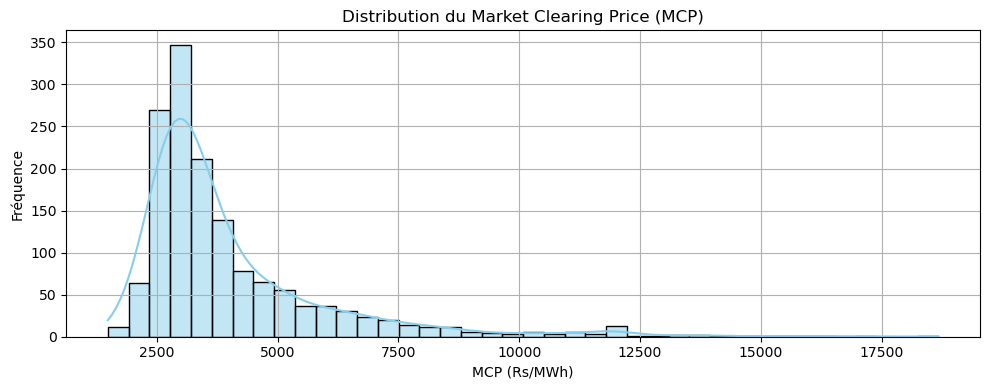

In [231]:
# 1. Distribution du MCP
plt.figure(figsize=(10, 4))
sns.histplot(df_final["MCP"], bins=40, kde=True, color='skyblue')
plt.title("Distribution du Market Clearing Price (MCP)")
plt.xlabel("MCP (Rs/MWh)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()

* **Observation** : la distribution est clairement **asymétrique à droite** (longue traîne).
* **Interprétation** : la majorité des prix sont concentrés entre 2000 et 5000 Rs/MWh, mais des pics extrêmes apparaissent jusqu’à 18000 Rs/MWh.
* **Conclusion** : une régression linéaire serait inadaptée à cause de cette forte **asymétrie et non-normalité**.

---

### 🔹 2. 🧵 Évolution temporelle du MCP

Voir sa variabilité dans le temps



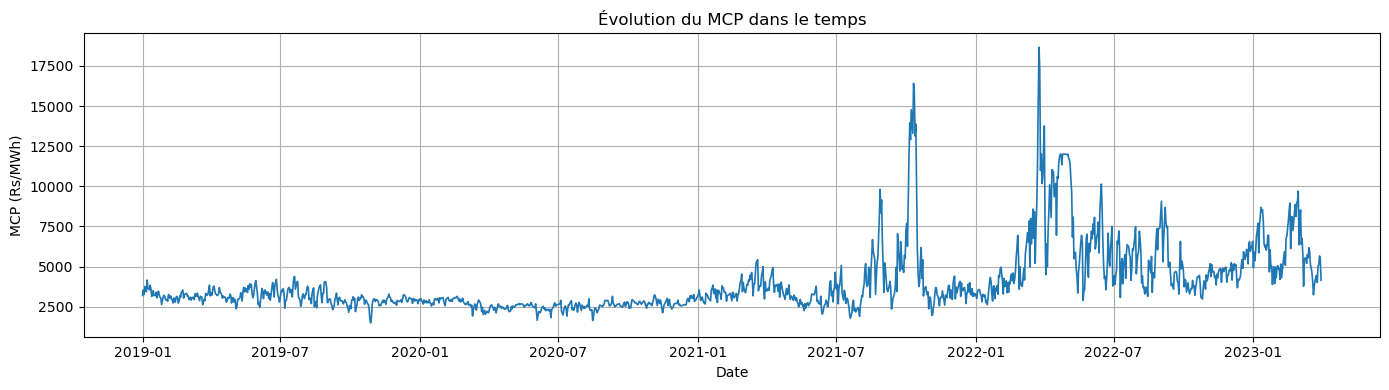

In [232]:
# 2. Évolution temporelle du MCP
plt.figure(figsize=(14, 4))
plt.plot(df_final["date"], df_final["MCP"], linewidth=1.2)
plt.title("Évolution du MCP dans le temps")
plt.xlabel("Date")
plt.ylabel("MCP (Rs/MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

* **Observation** : stabilité relative entre 2019–2020, mais **volatilité croissante** à partir de 2021 avec de nombreux pics.
* **Interprétation** : des événements extérieurs ou des déséquilibres offre-demande affectent fortement les prix.
* **Conclusion** : il y a des **non-linéarités et des chocs soudains** → modèle robuste nécessaire pour gérer cela.

---

### 🔹 3. 🔗 Corrélation entre variables

Pour repérer les plus influentes

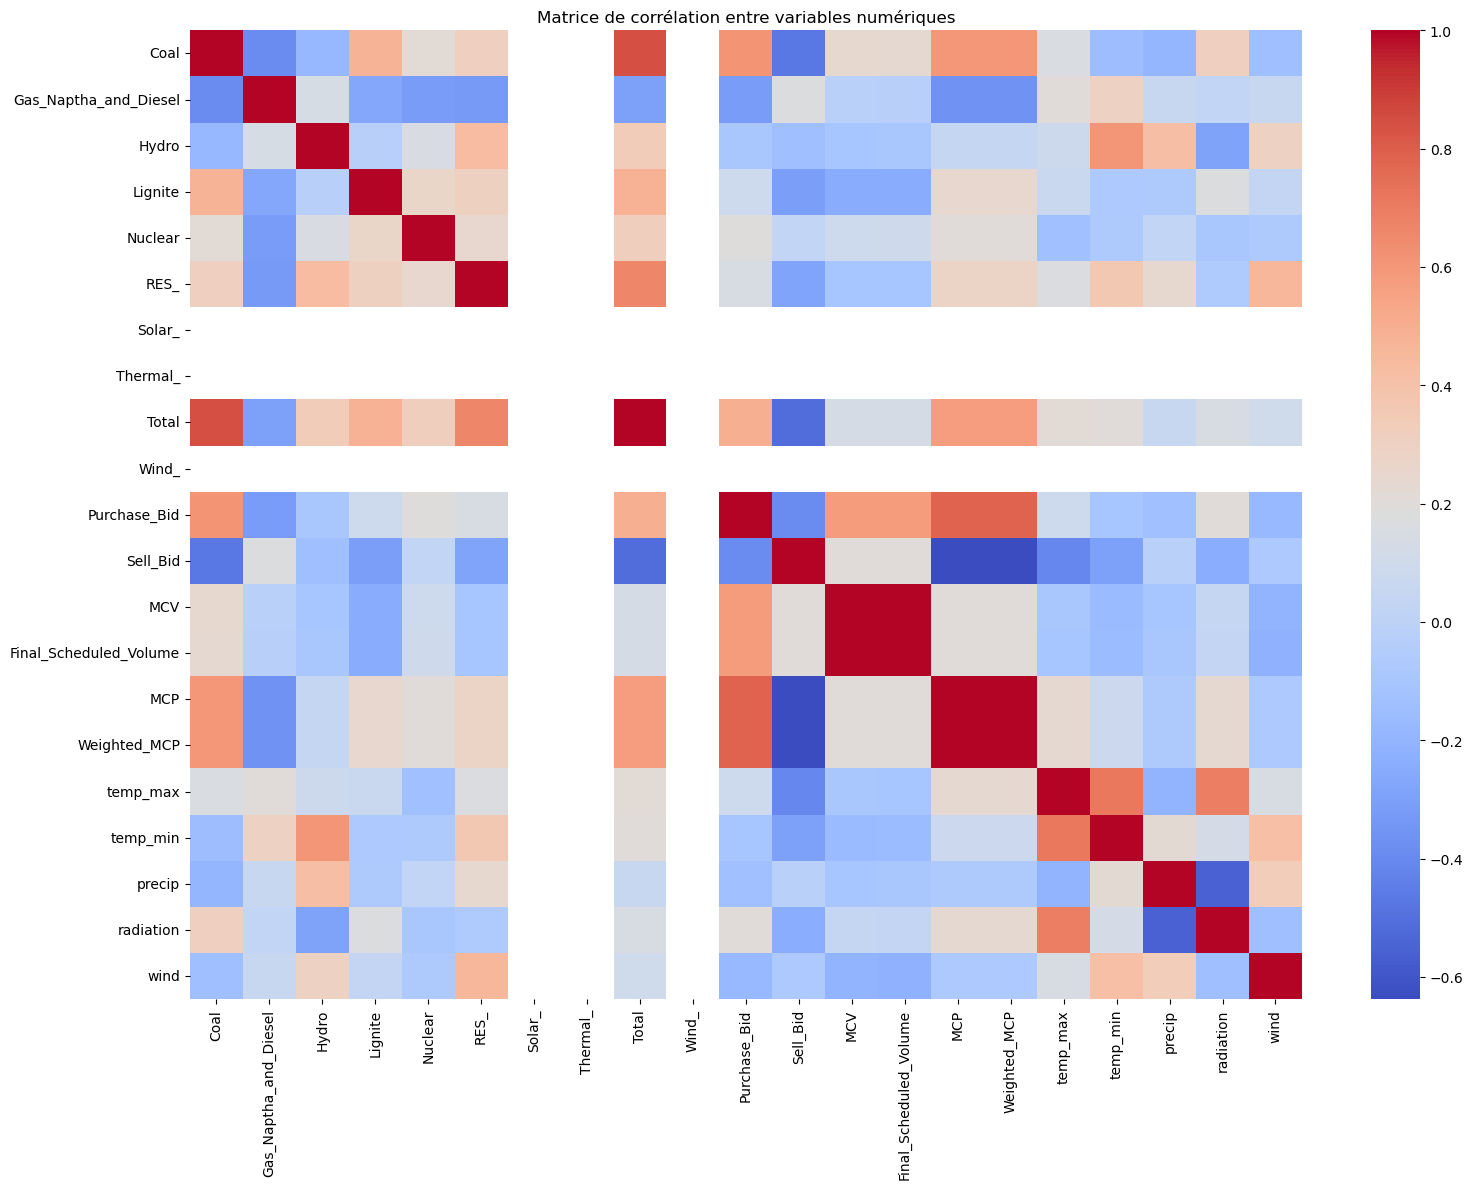

In [233]:
# 3. Matrice de corrélation
plt.figure(figsize=(16, 12))
corr_matrix = df_final.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Matrice de corrélation entre variables numériques")
plt.tight_layout()
plt.show()

## 🔍 **Lecture ciblée de la matrice de corrélation**

### 🎯 Cible principale : `MCP`

* **Corrélations positives** :

  * `Purchase_Bid` (≈ +0.5) → une hausse de la demande d’achat est **logiquement liée à une hausse du prix**.
  * `Gas_Naptha_and_Diesel` → corrélation modérée : ces sources coûteuses sont souvent activées en cas de **stress du réseau**, poussant le MCP vers le haut.

* **Corrélations négatives** :

  * `Sell_Bid` (≈ -0.4) → offre excédentaire fait **baisser** le MCP.
  * `Final_Scheduled_Volume`, `MCV` → également négatives, reflétant que **plus le volume est élevé, plus le marché est détendu**, donc prix plus bas.

* **Corrélations météorologiques** :

  * `temp_max` et `radiation` légèrement **positives** → une demande accrue en été ?
  * `precip` et `wind` assez **neutres à légèrement négatives** → effet diffus ou sous-estimé ici.

---

## 🔧 Autres observations utiles :

* Les **variables thermiques classiques** (Coal, Lignite, Thermal\_) sont **faiblement corrélées directement au MCP**, mais elles sont corrélées entre elles (effet d’inertie probable).
* `Weighted_MCP` est très **corrélé à MCP** (≈1) → normal, c’est une version pondérée, donc **à exclure du modèle** pour éviter la fuite de données (**data leakage**).

### 🔹 4. 📈 Scatter plots entre production & prix

Ex : `Coal` vs `MCP`, `Hydro` vs `MCP`, etc.

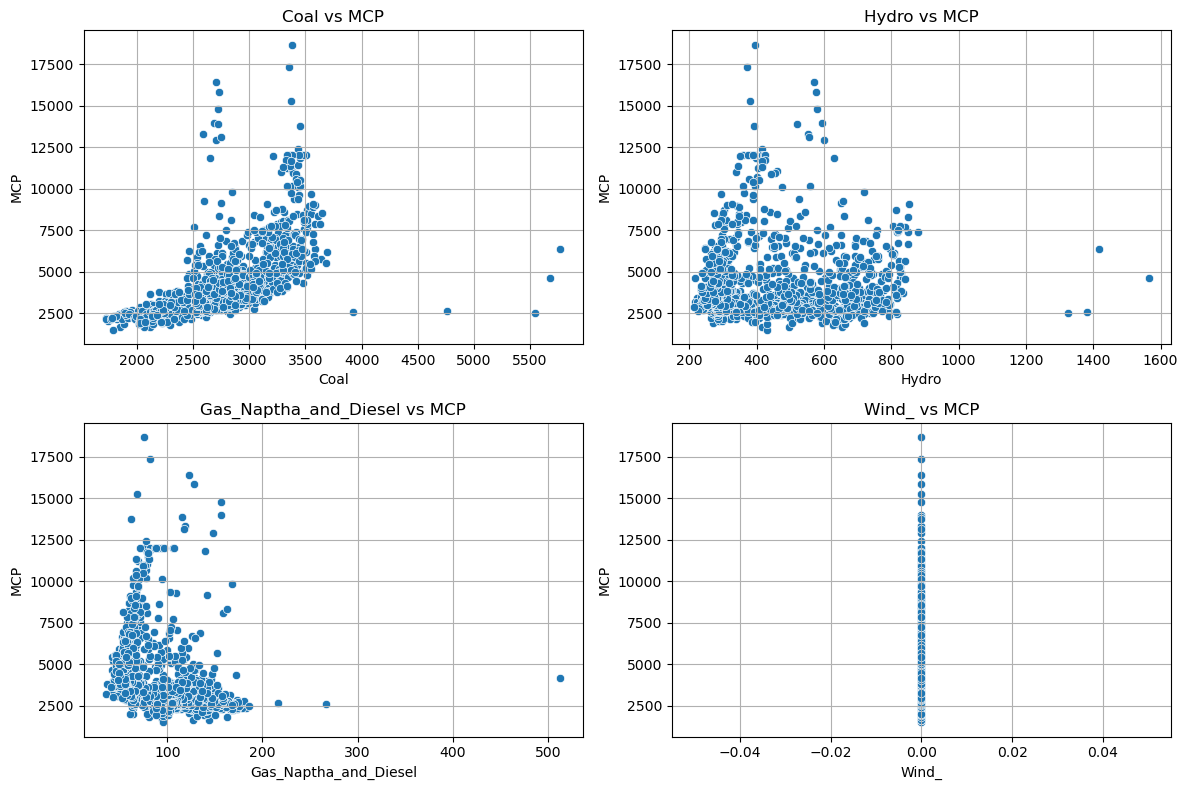

In [269]:
top_sources = ["Coal", "Hydro", "Gas_Naptha_and_Diesel", "Wind_"]

# Création d'une grille 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, source in enumerate(top_sources):
    if source in df_final.columns:
        sns.scatterplot(data=df_final, x=source, y="MCP", ax=axes[i])
        axes[i].set_title(f"{source} vs MCP")
        axes[i].grid(True)

plt.tight_layout()
plt.show()

### 🔄 **Coal vs MCP**

* **Observation** : relation **non linéaire**, avec une **forme courbe et des ruptures de tendance**.
* **Interprétation** : plus la production de charbon augmente, plus le MCP tend à croître, mais de façon irrégulière.
* **Conclusion** : une **modélisation non linéaire** (comme les arbres) serait plus appropriée.

---

### 💧 **Hydro vs MCP**

* **Observation** : pas de relation linéaire claire ; concentration des points dans la zone basse du MCP.
* **Interprétation** : la production hydraulique semble **moins corrélée directement** au prix.
* **Conclusion** : peut-être utile comme **feature secondaire**, mais pas prédictive seule.

---

### 🔥 **Gas\_Naptha\_and\_Diesel vs MCP**

* **Observation** : relation curieuse avec un **pic de MCP pour des valeurs moyennes** de production.
* **Interprétation** : ces sources sont **peu utilisées** mais associées à des périodes tendues du marché → potentiellement **prédictif des pics**.
* **Conclusion** : **indicateur intéressant de tension du marché**.

---

### 🌬️ *Wind vs MCP**

* **Observation** : données à zéro uniquement → probablement **pas de données disponibles** ou non fusionnées correctement.
* **Conclusion** : à **exclure pour le moment** ou à **revoir au niveau preprocessing**.

## ✅ Conclusion & Modèle à privilégier

* La structure des données, leur **variabilité temporelle**, et les **relations non linéaires** observées entre les sources d’énergie et le prix MCP **écartent d’emblée** les modèles linéaires simples.
* De plus, la présence de **valeurs extrêmes** nécessite un modèle **robuste au bruit et aux outliers**.


Passons à l'étape suivante ! Voici un **pipeline complet avec Random Forest** pour prédire le **MCP** (`Market Clearing Price`) :

---

### 🛠️ **Séparation des données**


In [235]:
# Base de travail : copie sécurisée
df = df_final.copy()

# Suppression colonnes inutiles surtout pour eviter data leakage sinon bonne perfommance mais absurde du coup
df = df.drop(columns=["date", "Weighted_MCP", "Purchase_Bid", "Sell_Bid", "MCV", "Final_Scheduled_Volume"], errors='ignore')

# Supprimer les lignes où la cible 'MCP' est NaN
df = df.dropna(subset=["MCP"])

# Cible et features
y = df["MCP"]
X = df.drop(columns=["MCP"])

### 🧪 Split des données

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 📊 Séparation des colonnes numériques et catégorielles

In [237]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

### ⚙️ Transformateurs

In [238]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### 🏗️ Préprocesseur combiné

In [239]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### 🌲 Pipeline complet

In [240]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

### 🔍 Grille d'hyperparamètres

In [241]:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}
print("NaN dans X_train :", X_train.isnull().sum().sum())
print("NaN dans y_train :", y_train.isnull().sum())


NaN dans X_train : 0
NaN dans y_train : 0


### 🔁 8. GridSearchCV

In [242]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Coal',
                                                                          'Gas_Naptha_and_Diesel',
                                                                          'Hydro',
                                                                          'Lignite',
                                                                          'Nuclear',
                                                                          'RES_',
                                                                          'Solar_',
                                  

### ✅ Meilleurs paramètres

In [243]:
print("Meilleurs paramètres :", grid_search.best_params_)

Meilleurs paramètres : {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}


---

### 🔍 Analyse rapide :

* **`max_depth=None`** :
  Le modèle n’impose **aucune limite à la profondeur des arbres**, ce qui signifie que chaque arbre peut se développer jusqu'à pureté maximale (chaque feuille contient des échantillons très homogènes).
  ➤ ⚠️ Peut conduire à **overfitting** si le jeu de données n'est pas régularisé ou si le nombre d’arbres est faible.

* **`min_samples_split=2`** :
  Cela permet de **scinder un nœud tant qu'il y a au moins 2 échantillons**. C’est la valeur minimale possible, donc les arbres peuvent se développer très profondément.
  ➤ Cela **renforce la complexité** de chaque arbre, encore un risque potentiel d'overfitting.

* **`n_estimators=50`** :
  Le modèle utilise **50 arbres**, ce qui est **relativement modeste** (par défaut c’est 100).
  ➤ Moins d'arbres signifie **moins de stabilisation**, donc les prédictions peuvent être plus **sensibles au bruit** du dataset, **mais plus rapides à entraîner**.

---

### 🟡 Conclusion :

Ces paramètres favorisent des **arbres très complexes et profonds** (forte variance), mais avec un **nombre modéré d’arbres**, ce qui peut **limiter la généralisation**.
Tu peux :

* Augmenter `n_estimators` à 100 ou plus pour une prédiction plus stable.
* Fixer un `max_depth` raisonnable (ex. 10–20) pour éviter l’overfitting.
* Tester avec `min_samples_split=5` ou `10` pour rendre les arbres moins "fragiles".

Mais si notre score est bon et que les résultats sont cohérents **sur les données de test**, ces paramètres peuvent être acceptables.


In [244]:
y_pred = grid_search.predict(X_test)

print("MAE  :", mean_absolute_error(y_test, y_pred))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²   :", r2_score(y_test, y_pred))
print("MCP min :", y.min())
print("MCP max :", y.max())
print("MCP mean:", y.mean())


MAE  : 547.2989085578002
RMSE : 1098.590152615075
R²   : 0.744262011173908
MCP min : 1488.1669791666666
MCP max : 18673.715416666666
MCP mean: 4025.9610253598726


---

### 📈 **Analyse des performances du modèle :**

#### 🔹 **MAE : 547.30**

* Cela signifie que, **en moyenne**, le modèle se trompe de **547 INR/MWh** par prédiction.
* Rapporté à la **valeur moyenne du MCP (4026)**, cela représente environ **13,6 % d’erreur absolue moyenne**, ce qui est **raisonnable mais perfectible**.

#### 🔹 **RMSE : 1098.59**

* L’erreur quadratique moyenne est **plus du double du MAE**, ce qui suggère que **des écarts importants subsistent** sur certaines prédictions (le modèle a tendance à se tromper plus fortement sur certains cas).
* C’est une alerte sur la **variabilité des erreurs** du modèle : il est bon en général, mais peut parfois fortement se tromper.

#### 🔹 **R² : 0.744**

* Le modèle parvient à expliquer **environ 74,4 % de la variance** du MCP.
* Ce score est **solide pour un problème de régression réelle**, mais montre qu’il reste **environ 25 % de la variabilité non capturée** par les variables actuelles.

---


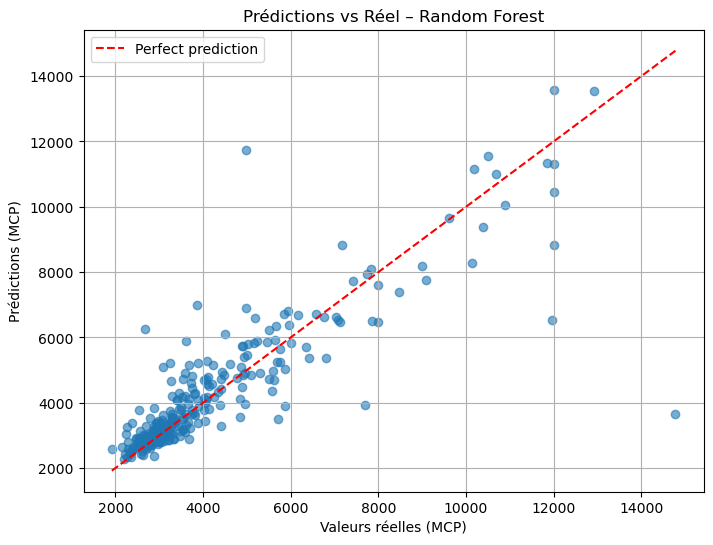

In [245]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect prediction')
plt.xlabel("Valeurs réelles (MCP)")
plt.ylabel("Prédictions (MCP)")
plt.title("Prédictions vs Réel – Random Forest")
plt.legend()
plt.grid(True)
plt.show()


---

### 🎯 **Analyse du nuage de points**

Ce graphique illustre la qualité de notre modèle de Random Forest à prédire le **Market Clearing Price (MCP)**.

#### 🔸 **Alignement sur la diagonale**

* La **ligne rouge en pointillé** représente une prédiction parfaite : chaque point devrait idéalement se trouver **exactement dessus** si le modèle était parfait.
* Dans notre cas, une grande partie des prédictions sont **assez proches** de cette ligne, surtout dans la zone **2000–5000 INR/MWh**, ce qui indique que le modèle apprend bien la tendance générale dans cette plage de valeurs.

---

### 🔍 **Comportements observés**

#### ✅ Zone basse à moyenne (2000–6000 INR)

* Forte concentration des points.
* Peu de dispersion : **les prédictions sont précises** sur la majorité des cas standards du marché.
* C’est cohérent avec la **valeur moyenne du MCP (\~4026)** : le modèle performe bien là où il a vu le plus de données.

#### ⚠️ Zone haute (>6000 INR)

* Plus on s’éloigne des valeurs centrales, plus les points sont **éparpillés autour de la diagonale**.
* On observe des **sous-estimations et sur-estimations importantes** sur certains pics (jusqu’à 14 000 INR/MWh).
* Cela suggère que le modèle **généralise moins bien** les valeurs extrêmes, probablement parce qu’elles sont rares ou influencées par des facteurs non présents dans les données (ex. : événements ponctuels, contraintes réseau, etc.).

---


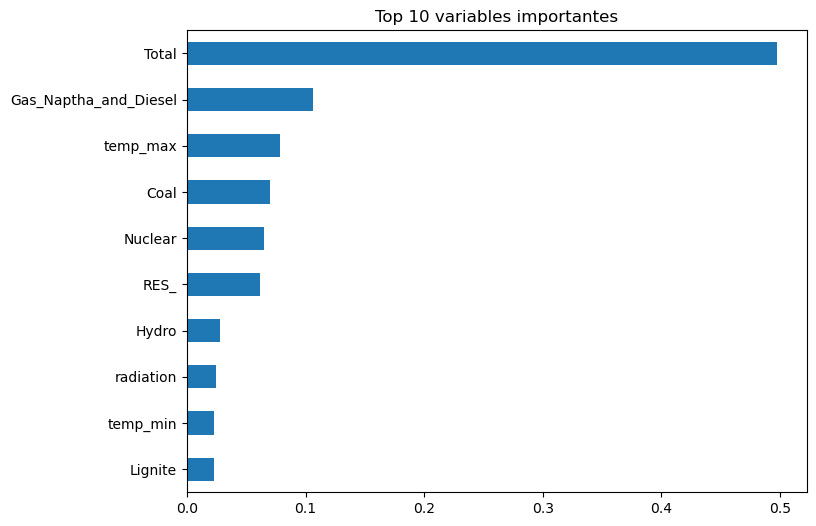

In [246]:
importances = grid_search.best_estimator_.named_steps["regressor"].feature_importances_
feature_names = X_train.columns

# Tri et affichage
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh', title="Top 10 variables importantes", figsize=(8, 6))
plt.gca().invert_yaxis()
plt.show()


---

### 🧠 **Analyse des variables importantes**

Ce graphique montre les variables qui ont le plus influencé les prédictions du modèle Random Forest.

#### 🔹 **1. `Total` (puissance totale produite)**

* **Extrêmement dominante**, représentant à elle seule près de **50 % de l’importance**.
* Cela indique que le **volume total de production électrique** est de loin le facteur le plus déterminant pour fixer le prix du marché — ce qui est logique : **plus l’offre est élevée, plus le prix a tendance à baisser** (et inversement).

#### 🔹 **2. `Gas_Naptha_and_Diesel`**

* Deuxième variable la plus influente.
* Ces sources sont souvent **coûteuses** et utilisées pour **répondre à la demande de pointe**, ce qui peut expliquer leur lien fort avec des hausses du MCP.

#### 🔹 **3. Température (`temp_max`)**

* La météo, en particulier la température maximale, joue un rôle significatif.
* Elle influence directement la **consommation énergétique** (climatisation, refroidissement…), et donc **la demande** → ce qui impacte le prix.

#### 🔹 **4 à 6. `Coal`, `Nuclear`, `RES_`**

* Les autres sources de production comme le charbon, le nucléaire et les renouvelables ont un impact modéré.
* Leur importance dépend de **leur stabilité**, **coût de production**, et **variabilité** (surtout pour les renouvelables).

#### 🔹 **7 à 10. `Hydro`, `radiation`, `temp_min`, `Lignite`**

* Ces variables ont un **poids réduit**, mais non négligeable.
* Elles peuvent agir comme **modulateurs** dans certaines conditions spécifiques (ex. : saisons, météo extrême, capacité hydroélectrique disponible, etc.).

---

### 📌 **Conclusion**

* Le modèle s’appuie majoritairement sur **l’offre totale disponible** et les **sources thermiques coûteuses**, ce qui est cohérent économiquement.
* L’impact notable des **données météo** confirme leur pertinence pour prédire le prix du marché.
* Ce type d’analyse est crucial pour **réduire la dimensionnalité**, améliorer l’interprétabilité, ou encore orienter des politiques énergétiques basées sur les données.

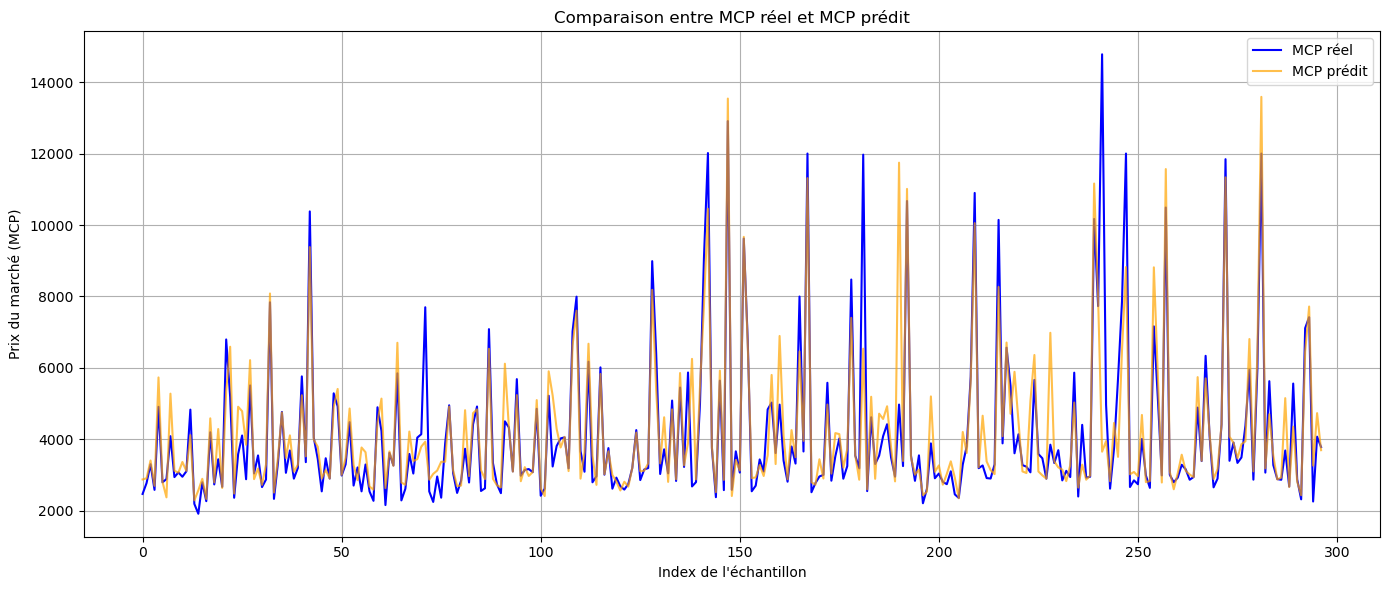

In [247]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ S'assurer que y_test et y_pred sont bien alignés
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='MCP réel', color='blue')
plt.plot(y_pred, label='MCP prédit', color='orange', alpha=0.7)

plt.title("Comparaison entre MCP réel et MCP prédit")
plt.xlabel("Index de l'échantillon")
plt.ylabel("Prix du marché (MCP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 🔍 Analyse :

* 🔄 **Tendance bien captée** : Le modèle arrive globalement à suivre la dynamique des prix du marché, en particulier les périodes de stabilité.
* 📉 **Écarts visibles sur les pics** : Les plus grandes erreurs se situent au niveau des **pics de prix** (valeurs extrêmes), que le modèle a tendance à **sous-estimer** ou **surestimer légèrement**, ce qui est courant dans les modèles de régression sur des données volatiles.
* 🎯 **Bonne précision globale** : Malgré ces écarts ponctuels, la **superposition des deux courbes** reste assez cohérente, ce qui est en ligne avec le **R² de 0.74**, indiquant que le modèle explique environ 74 % de la variance des données.
* ⚠️ **Potentiel d’amélioration** : Il pourrait être intéressant de :

  * mieux modéliser les jours avec des MCP très élevés,
  * ou introduire des **caractéristiques exogènes** comme les événements exceptionnels ou les variations hebdomadaires.

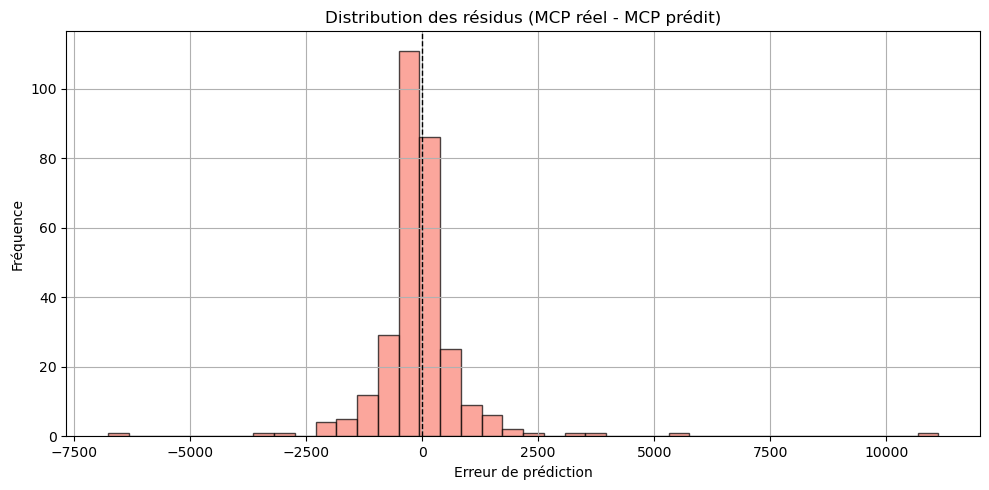

In [248]:
import matplotlib.pyplot as plt

# ✅ Calcul des résidus
residuals = y_test.values - y_pred

# ✅ Tracé de l'histogramme
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=40, color='salmon', edgecolor='black', alpha=0.7)
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)

plt.title("Distribution des résidus (MCP réel - MCP prédit)")
plt.xlabel("Erreur de prédiction")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()


---

### 📊 **Analyse de la distribution des résidus**

L'histogramme des résidus (MCP réel – MCP prédit) présente une distribution :

* **Centrée autour de zéro**, ce qui indique qu’il n’y a **pas de biais systématique** majeur : le modèle ne surestime ni ne sous-estime en moyenne les valeurs du MCP.
* **Asymétrique et étalée**, avec quelques **valeurs extrêmes** (jusqu’à ±10 000) : cela montre que le modèle a du mal à prédire certains pics de prix ou événements rares.
* La **concentration principale** des erreurs se situe dans une bande étroite autour de zéro (entre environ -1000 et +1000), ce qui est **bon signe** sur les performances globales.

---


### 🔁 Pourquoi tester XGBoost ?

XGBoost (Extreme Gradient Boosting) est un algorithme d’ensemble basé sur des arbres de décision, comme Random Forest, **mais beaucoup plus puissant** dans certains contextes :

* ✅ **Plus robuste** face aux données bruitées ou corrélées,
* ✅ **Meilleure généralisation** grâce à la régularisation intégrée,
* ✅ **Performant sur les grands volumes de données**,
* ✅ Et souvent **meilleur sur les valeurs extrêmes**, un point critique dans notre contexte énergétique.

---

### 🎯 Objectif

Nous allons maintenant :

1. **Configurer un pipeline XGBoost** avec `Pipeline` de `sklearn`.
2. Réaliser une **recherche d’hyperparamètres** via `GridSearchCV` ou `RandomizedSearchCV`.
3. Comparer les résultats avec ceux de Random Forest sur :

   * MAE, RMSE, R²
   * Graphique des prédictions
   * Importance des variables
   * Résidus

---

In [250]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

### 📌 Pipeline : mise à l'échelle + modèle XGBoost

In [251]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

### 🔍 Paramètres à tester

In [252]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__subsample': [0.8, 1]
}

### 🎯 Recherche des meilleurs hyperparamètres

In [256]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     g

### ✅ Meilleurs paramètres

In [257]:
print("Meilleurs paramètres :", grid_search.best_params_)

Meilleurs paramètres : {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}


### ✅ Prédictions

In [258]:
y_pred = grid_search.predict(X_test)

### ✅ Évaluation

In [259]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

MAE  : 482.62
RMSE : 998.96
R²   : 0.7885


---

### 🎯 **Analyse des résultats XGBoost**

* **MAE : 482.62**

  * L’erreur absolue moyenne est inférieure à 500, ce qui signifie que, **en moyenne**, le modèle se trompe de \~483 unités sur le MCP. C’est une amélioration nette par rapport à la Random Forest (547).

* **RMSE : 998.96**

  * L'erreur quadratique moyenne reste inférieure à 1000, ce qui indique que les **erreurs importantes (pics)** sont mieux gérées qu’avec la Random Forest (RMSE : 1098).

* **R² : 0.7885**

  * Le modèle explique **près de 79 % de la variance** du prix MCP. C’est un excellent score, surtout pour un problème aussi bruité et multifactoriel.

---

### 🔄 Comparaison rapide avec Random Forest :

| Modèle        | MAE        | RMSE       | R²         |
| ------------- | ---------- | ---------- | ---------- |
| Random Forest | 547.30     | 1098.59    | 0.7443     |
| **XGBoost**   | **482.62** | **998.96** | **0.7885** |

✅ **Conclusion** : XGBoost surpasse la Random Forest sur **tous les indicateurs**, ce qui démontre sa capacité à mieux capturer les relations complexes dans les données.

---

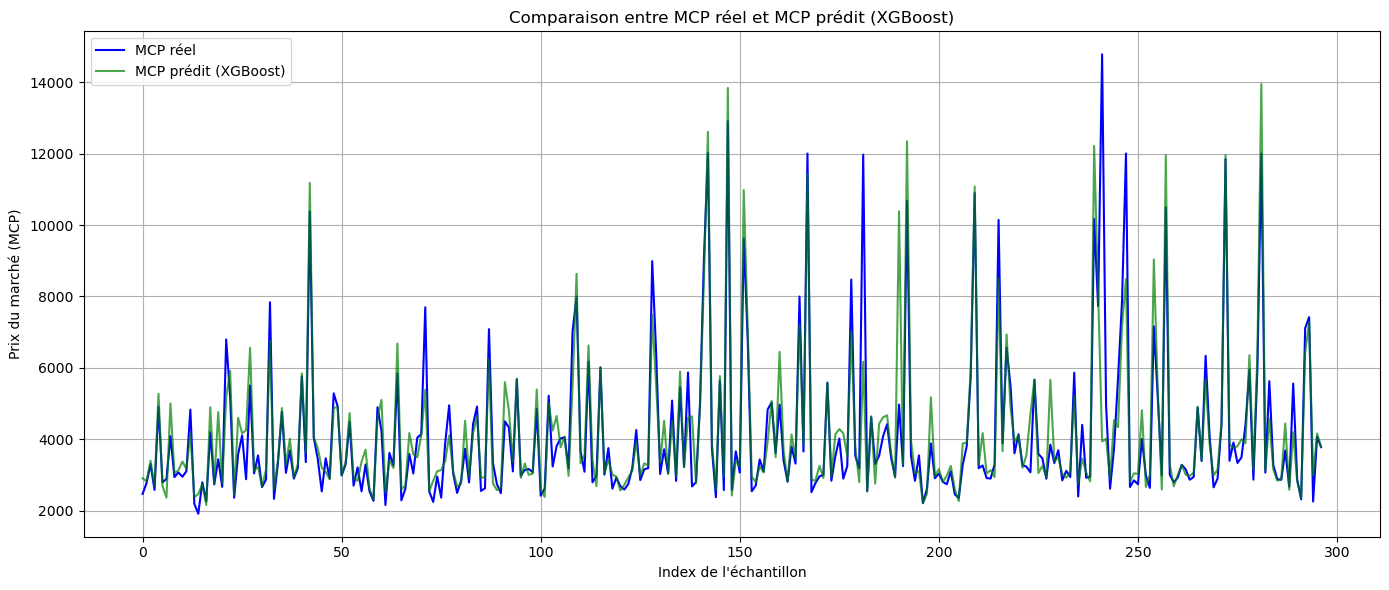

In [261]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='MCP réel', color='blue')
plt.plot(y_pred, label='MCP prédit (XGBoost)', color='green', alpha=0.7)

plt.title("Comparaison entre MCP réel et MCP prédit (XGBoost)")
plt.xlabel("Index de l'échantillon")
plt.ylabel("Prix du marché (MCP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 📈 **Courbe des Prédictions vs Valeurs Réelles (MCP)**

* 🔍 **Alignement global :** Les courbes bleue (réelle) et verte (prédite par XGBoost) se suivent assez bien, notamment sur la plupart des échantillons à moyenne ou basse valeur.
* 📉 **Déviations :** On observe quelques pics où le modèle sous-estime ou surestime fortement le MCP (par exemple entre les index 100 et 200 ou vers la fin).
* ✅ **Conclusion :** Le modèle capte bien les tendances globales, même s’il a encore du mal avec les extrêmes. Cela reste cohérent avec un R² de **0.7885**.

---




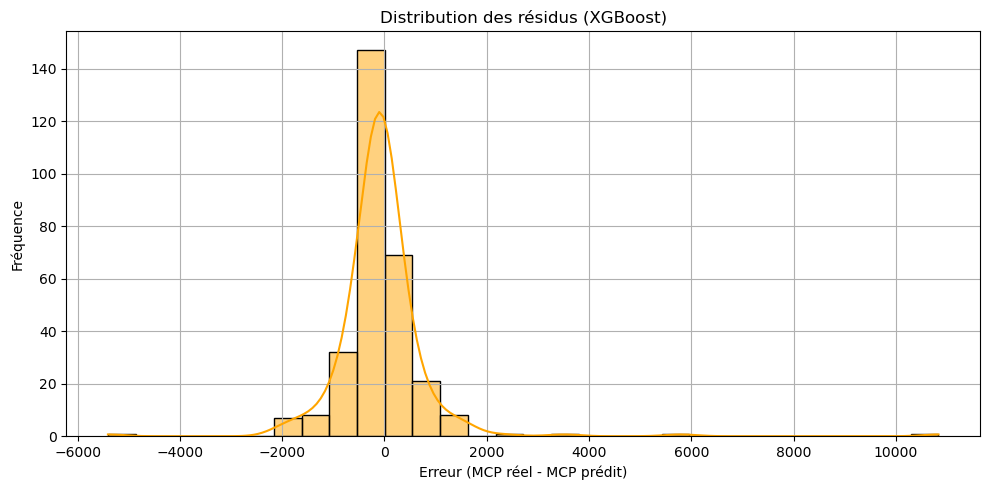

In [263]:
residuals = y_test.values - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, color="orange")
plt.title("Distribution des résidus (XGBoost)")
plt.xlabel("Erreur (MCP réel - MCP prédit)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 **Histogramme des résidus (erreurs de prédiction)**

* 🟩 **Centré sur 0 :** La distribution des erreurs est centrée autour de zéro, ce qui montre **peu de biais systématique**.
* 🔁 **Asymétrie légère :** Il existe une petite asymétrie droite (quelques grosses erreurs positives), indiquant que le modèle a tendance à **sous-estimer dans certains cas extrêmes**.
* 📦 **Forme proche de la normale :** La forme générale est proche d’une distribution normale (courbe lisse), ce qui est bon signe pour la robustesse du modèle.

---

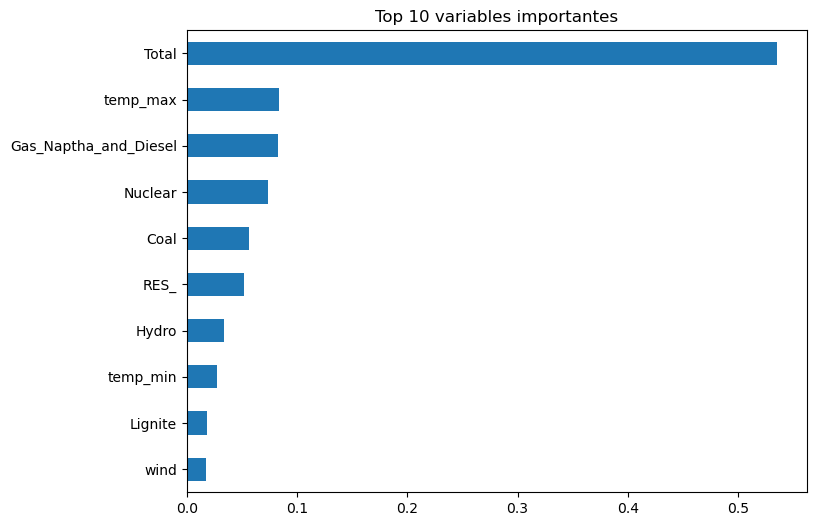

In [266]:
importances = grid_search.best_estimator_.named_steps["regressor"].feature_importances_
feature_names = X_train.columns

# Tri et affichage
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh', title="Top 10 variables importantes", figsize=(8, 6))
plt.gca().invert_yaxis()
plt.show()

### 📌 **Top 10 variables importantes**

* 🥇 **Total** (probablement la demande totale) est de loin la variable la plus influente (> 0.5), ce qui est cohérent avec la logique économique du marché de l’énergie.
* 🔥 **temp\_max** et **Gas\_Naptha\_and\_Diesel** apparaissent aussi importants, suggérant que la météo (chauffe, refroidissement) et les moyens de production fossiles influencent fortement le prix.
* ⚡ Les autres variables (Nuclear, Coal, RES\_, Hydro, etc.) contribuent de manière secondaire mais utile à la précision.

---

### ✅ En résumé :

| Critère                | Observation                                                |
| ---------------------- | ---------------------------------------------------------- |
| **MAE**                | 482.62 → Erreur moyenne faible vu l’échelle des prix       |
| **RMSE**               | 998.96 → Meilleure que le modèle précédent (Random Forest) |
| **R²**                 | 0.7885 → Excellente capacité explicative                   |
| **Conclusion globale** | XGBoost est plus performant et plus robuste                |

---

---

# 🎯 **Conclusion générale du projet**

À la suite de mon second entretien avec ENGIE pour la mission en Inde, on m’a proposé de partager d’éventuels projets complémentaires ou des éléments que je n’aurais pas eu l’occasion de présenter. J’ai souhaité saisir cette opportunité en me lançant dans un défi personnel le week-end suivant : construire un modèle de **prédiction du prix de l’électricité (MCP)** sur le marché indien.

L’objectif de ce projet était double :

1. **Montrer concrètement mes compétences techniques** en machine learning, traitement de données et visualisation ;
2. Et **répondre à une problématique métier réelle** en lien avec les enjeux d’ENGIE sur le marché de l’énergie.

Le plus grand défi a été de **trouver des données fiables** et exploitables, notamment sur les prix spot d’électricité et la production énergétique. J’ai pu constituer un jeu de données cohérent en croisant plusieurs sources (prix de l’Indian Energy Exchange, données météo, production électrique par source, etc.).

Après la préparation des données, j’ai entraîné plusieurs modèles de régression, notamment **Random Forest** et **XGBoost**. Ce dernier s’est révélé le plus performant, atteignant un R² de **0.7885**, ce qui montre une bonne capacité du modèle à expliquer les variations du prix de marché. J’ai aussi intégré plusieurs visualisations (résidus, importance des variables, courbe de prédiction) pour analyser les performances et comprendre les facteurs clés du modèle.

Bien entendu, ce projet a été réalisé en **très peu de temps** (entre vendredi et dimanche), et comme tout travail de modélisation, il mériterait d’être approfondi, optimisé et validé avec davantage de recul. Cela dit, j’ai voulu vous le présenter tel quel, en toute transparence, car je pense qu’il reflète :

* ma **réactivité**,
* ma **capacité à me mobiliser rapidement autour d’un problème complexe**,
* et surtout ma **motivation à rejoindre une entreprise innovante comme ENGIE**.

Je reste bien sûr à votre disposition pour toute question ou retour, et je serai ravi d’échanger sur les pistes d’amélioration ou d’application réelle de ce type de modèle.

Merci encore pour cette opportunité et pour votre écoute attentive.

Bien cordialement,
**Enzo CHERIF**